<a href="https://colab.research.google.com/github/georgilos/Bert-for-text-classification/blob/main/SPAL%2BBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Cloning the repository containing itinial training data, evaluation & unlabeled data

In [1]:
!git clone https://github.com/georgilos/Bert-for-text-classification.git

Cloning into 'Bert-for-text-classification'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 184 (delta 21), reused 18 (delta 7), pack-reused 137 (from 1)
Receiving objects: 100% (184/184), 37.38 MiB | 11.52 MiB/s, done.
Resolving deltas: 100% (70/70), done.


### Changing directory


In [2]:
%cd Bert-for-text-classification/

/content/Bert-for-text-classification


In [87]:
%ls

Active+BERT.ipynb            diversity_sampling.py  pytorch_clusters.py  training_data/
active_learning_basics.py    evaluation_data/       README.md            uncertainty_sampling.py
active_learning.py           LICENSE                requirements.txt     unlabeled_data/
advanced_active_learning.py  models/                SPAL+Bert.ipynb      validation_data/


### Checking gpu is on

In [88]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Reading the .csv files


In [3]:
import pandas as pd

# Load training data
train_hate = pd.read_csv('training_data/related.csv', header=None)
train_non_hate = pd.read_csv('training_data/not_related.csv', header=None)

# Load evaluation data
eval_hate = pd.read_csv('evaluation_data/related.csv', header=None)
eval_non_hate = pd.read_csv('evaluation_data/not_related.csv', header=None)

# Load unlabeled data
unlabeled_data = pd.read_csv('unlabeled_data/unlabeled_data.csv', header=None)

# Assign column names
columns = ['ID', 'TEXT', 'LABEL', 'UNKNOWN1', 'UNKNOWN2']
train_hate.columns = train_non_hate.columns = eval_hate.columns = eval_non_hate.columns = columns
unlabeled_data.columns = ['ID', 'TEXT']  # Unlabeled data doesn't have LABEL

# Keep only relevant columns
train_hate = train_hate[['ID', 'TEXT', 'LABEL']]
train_non_hate = train_non_hate[['ID', 'TEXT', 'LABEL']]
eval_hate = eval_hate[['ID', 'TEXT', 'LABEL']]
eval_non_hate = eval_non_hate[['ID', 'TEXT', 'LABEL']]
unlabeled_data = unlabeled_data[['ID', 'TEXT']]  # Unlabeled data has no labels

# Combine training and evaluation data
train_data = pd.concat([train_hate, train_non_hate], ignore_index=True)
eval_data = pd.concat([eval_hate, eval_non_hate], ignore_index=True)

# Inspect the datasets
print("Training Data:")
print(train_data.head())
print("Evaluation Data:")
print(eval_data.head())
print("Unlabeled Data:")
print(unlabeled_data.head())


Training Data:
         ID                                               TEXT  LABEL
0  10241698  employees are either pedophiles or trying to r...      1
1  10238878  how about this lets go to retard war lets see ...      1
2  10119028                     lol you sick whiny tds pussies      1
3  10536279  she is a dumbass a public embarrassment for he...      1
4  10236262  i wanted to reply lets goooooo brandon but i d...      1
Evaluation Data:
       ID                                               TEXT  LABEL
0  585871  bitch i turn on the tv and is drunk af also ho...      1
1  215768  hicks and hillbillies are taking over the repu...      1
2  311431  the whole bunch is pure trash including the se...      1
3  452016  these gay drunk dudes on are very embarrassing...      1
4  109292  this dude is drunk af and crosseyed on in the ...      1
Unlabeled Data:
         ID                                               TEXT
0  10000000  if youre going down might as well go down in f..

###Checking the data contents



In [6]:
print( train_data.iloc[9])

ID                                          10942227
TEXT     twitter is retarded and they aren't doctors
LABEL                                              1
Name: 9, dtype: object


### Must - link pairs

In [4]:
from itertools import combinations

def generate_must_link(data):
    same_class_pairs = []
    for label in data['LABEL'].unique():
        subset = data[data['LABEL'] == label]
        same_class_pairs.extend(list(combinations(subset.index, 2)))
    return same_class_pairs

must_link_pairs = generate_must_link(train_data)
print("First 5 Must-Link Pairs:", must_link_pairs[:5])  # Show first 5 pairs
print ("Totat Must-Link Pairs:", len(must_link_pairs))

First 5 Must-Link Pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
Totat Must-Link Pairs: 3615


### Checking the contents of a must-link pair

In [8]:
# Access the contents of the first must-link pair
first_pair = must_link_pairs[0]
print("First Must-Link Pair Indices:", first_pair)

# Access the corresponding data points
first_pair_data = train_data.iloc[list(first_pair)]
print("\nData for the first Must-Link Pair:\n", first_pair_data)

First Must-Link Pair Indices: (0, 1)

Data for the first Must-Link Pair:
          ID                                               TEXT  LABEL
0  10241698  employees are either pedophiles or trying to r...      1
1  10238878  how about this lets go to retard war lets see ...      1


### Cannot - link pairs

In [5]:
def generate_cannot_link(data):
    hate_indices = data[data['LABEL'] == 1].index
    non_hate_indices = data[data['LABEL'] == 0].index
    return [(i, j) for i in hate_indices for j in non_hate_indices]

cannot_link_pairs = generate_cannot_link(train_data)
print("First 5 Cannot-Link Pairs:", cannot_link_pairs[:5])  # Show first 5 pairs
print ("Total Cannot-Link Pairs:", len(cannot_link_pairs))

First 5 Cannot-Link Pairs: [(0, 10), (0, 11), (0, 12), (0, 13), (0, 14)]
Total Cannot-Link Pairs: 850


### Checking the contents of a cannot-link pair

In [10]:
# Access the contents of the first cannot-link pair
first_pair = cannot_link_pairs[0]
print("First Cannot-Link Pair Indices:", first_pair)

# Access the corresponding data points
first_pair_data = train_data.iloc[list(first_pair)]
print("\nData for the first Cannot-Link Pair:\n", first_pair_data)

First Cannot-Link Pair Indices: (0, 10)

Data for the first Cannot-Link Pair:
           ID                                               TEXT  LABEL
0   10241698  employees are either pedophiles or trying to r...      1
10  10410961          except on foreign soil not the same thing      0


### Creating BERT embedding of the data

In [ ]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

from transformers import BertTokenizer, BertModel
import torch
import numpy as np

def generate_embeddings(texts, tokenizer, model, batch_size=16, use_cls=True):

    embeddings = []
    for i in range(0, len(texts), batch_size):  # Create batches
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        if use_cls:
            # Extract [CLS] token embedding
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
        else:
            # Apply mean pooling
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)

    # Stack all embeddings into a single tensor
    return torch.cat(embeddings, dim=0)


# Generate embeddings for labeled data (train_data)
train_texts = train_data['TEXT'].tolist()
train_embeddings = generate_embeddings(train_texts, tokenizer, model, batch_size=16, use_cls=True)
print("Train Embeddings Shape:", train_embeddings.shape)

# Generate embeddings for unlabeled data
unlabeled_texts = unlabeled_data['TEXT'].tolist()
unlabeled_embeddings = generate_embeddings(unlabeled_texts, tokenizer, model, batch_size=16, use_cls=True)
print("Unlabeled Embeddings Shape:", unlabeled_embeddings.shape)


Train Embeddings Shape: torch.Size([95, 768])
Unlabeled Embeddings Shape: torch.Size([5001, 768])


### Save embeddings

In [ ]:
# Save train embeddings
torch.save(train_embeddings, 'train_embeddings.pt')

# Save unlabeled embeddings
torch.save(unlabeled_embeddings, 'unlabeled_embeddings.pt')


### Download them

In [ ]:
from google.colab import files

files.download('/content/Bert-for-text-classification/unlabeled_embeddings.pt')
files.download('/content/Bert-for-text-classification/train_embeddings.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Load embeddings (if downloaded from last session)

In [6]:
import torch

# Paths to the saved .pt files
train_embeddings_path = 'train_embeddings.pt'
unlabeled_embeddings_path = 'unlabeled_embeddings.pt'

# Load the embeddings
train_embeddings = torch.load(train_embeddings_path)
unlabeled_embeddings = torch.load(unlabeled_embeddings_path)

print("Train Embeddings Shape:", train_embeddings.shape)
print("Unlabeled Embeddings Shape:", unlabeled_embeddings.shape)


Train Embeddings Shape: torch.Size([95, 768])
Unlabeled Embeddings Shape: torch.Size([5001, 768])


<ipython-input-6-dea01f3a36cb>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_embeddings = torch.load(train_embeddings_path)
<ipython-input-6-dea01f3a36cb>:9: Future

### Combine embeddings

In [7]:
# Combine labeled and unlabeled embeddings
all_embeddings = torch.cat((train_embeddings, unlabeled_embeddings), dim=0)
print("Combined Embeddings Shape:", all_embeddings.shape)


Combined Embeddings Shape: torch.Size([5096, 768])


### Compute the pairwise distances between all embeddings

In [8]:
from scipy.spatial.distance import cdist
import numpy as np

# Convert embeddings to NumPy array if necessary
embeddings = all_embeddings.numpy()  # Combined embeddings from labeled and unlabeled data

# Compute pairwise distance matrix
distance_matrix = cdist(embeddings, embeddings, metric='cosine')
print("Distance Matrix Shape:", distance_matrix.shape)


Distance Matrix Shape: (5096, 5096)


### Constrained DBSCAN


In [9]:
import numpy as np
from collections import deque

def constrained_dbscan_with_constraints(distance_matrix, eps, min_samples, must_link, cannot_link):
    """
    Constrained DBSCAN implementation where constraints are applied during clustering.

    Parameters:
    - distance_matrix (ndarray): Pairwise distance matrix.
    - eps (float): Maximum distance to consider two points as neighbors.
    - min_samples (int): Minimum number of neighbors for a point to be a core point.
    - must_link (list of tuples): List of must-link pairs (index1, index2).
    - cannot_link (list of tuples): List of cannot-link pairs (index1, index2).

    Returns:
    - labels (ndarray): Cluster labels for each point. Noise is labeled as -1.
    """
    n = distance_matrix.shape[0] # # Get the total number of data points (number of rows in the distance matrix).
    labels = np.full(n, -1)  # Initialize all points as noise (-1)
    cluster_id = 0 # Start with cluster ID 0

    # Convert must-link and cannot-link constraints into dictionaries for quick lookup
    must_link_dict = {i: set() for i in range(n)}
    for i, j in must_link:
        must_link_dict[i].add(j)
        must_link_dict[j].add(i)

    cannot_link_dict = {i: set() for i in range(n)}
    for i, j in cannot_link:
        cannot_link_dict[i].add(j)
        cannot_link_dict[j].add(i)

    # Visit each point
    visited = np.full(n, False) # Checks if a point is unvisited and not yet part of a cluster

    def expand_cluster(point_idx):
        # Initialising a double-ended queue to store points for Breadth-First Search
        queue = deque([point_idx]) # Add the index of the initial point to it
        cluster_points = [] # Points that will be part of this cluster

        while queue:
            current_point = queue.popleft() # Retrieve and remove the leftmost element from the queue
            if visited[current_point]: # If a point is visited
                continue #Skip this point
            visited[current_point] = True # If not visited, mark it as such
            cluster_points.append(current_point) # Add point to the cluster_points list

            # Get neighbors of the current point based on pre-calculated distances in distance_matrix.
            # Points within a distance of 'eps' are considered neighbors.
            # np.where(...) returns indices of neighbors (using [0]).
            neighbors = np.where(distance_matrix[current_point] <= eps)[0]

            # Ensure cannot-link constraints are not violated
            valid_neighbors = []
            for neighbor in neighbors:
                # Check for indirect cannot-link violations
                if any(
                    neighbor in cannot_link_dict[other_point] for other_point in cluster_points
                ):
                    continue  # Skip this neighbor, as it creates an indirect cannot-link violation
                valid_neighbors.append(neighbor)

            print(f"Point {current_point}: {len(neighbors)} neighbors before filtering, {len(valid_neighbors)} after filtering.")
            neighbors = valid_neighbors

            # Add must-link neighbors to the cluster and queue
            for p in must_link_dict[current_point]:
                if p not in cluster_points:
                    queue.append(p)

            # If the current point has enough neighbors, include them in the cluster
            if len(neighbors) >= min_samples:
                for neighbor in neighbors:
                    if neighbor not in cluster_points:
                        queue.append(neighbor)

        # Assign the cluster ID to all points in the cluster
        for p in cluster_points:
            labels[p] = cluster_id


    for i in range(n):
        if visited[i] or labels[i] != -1:  # Skip visited or already clustered points
            continue

        # Check if the point is a core point
        neighbors = np.where(distance_matrix[i] <= eps)[0]
        if len(neighbors) < min_samples:
            continue  # Not a core point, remains noise

        # Expand the cluster
        expand_cluster(i)
        cluster_id += 1

    return labels

### Visualising the distance matrix

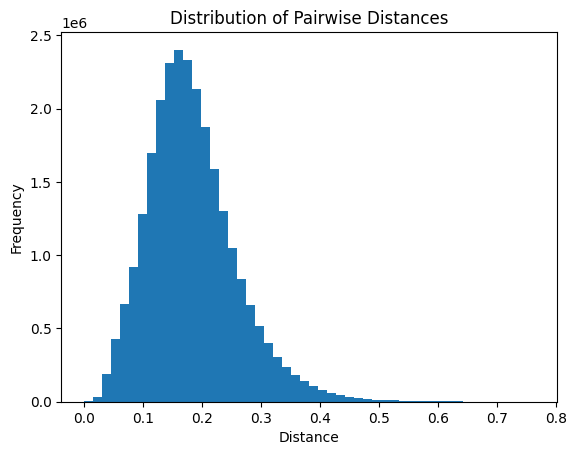

In [20]:
import matplotlib.pyplot as plt
plt.hist(distance_matrix.flatten(), bins=50)
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Pairwise Distances")
plt.show()


### Running constrained DBSCAN with eps and min_samples parameters

In [10]:
# Apply constrained DBSCAN
eps = 0.15  # Adjust based on distance matrix
min_samples = 5  # Minimum neighbors to form a cluster

adjusted_labels = constrained_dbscan_with_constraints(distance_matrix, eps, min_samples, must_link_pairs, cannot_link_pairs)
print("Adjusted Cluster Labels:", np.unique(adjusted_labels))


Point 0: 21 neighbors before filtering, 20 after filtering.
Point 1: 183 neighbors before filtering, 182 after filtering.
Point 2: 3269 neighbors before filtering, 3231 after filtering.
Point 3: 1706 neighbors before filtering, 1686 after filtering.
Point 4: 735 neighbors before filtering, 728 after filtering.
Point 5: 2801 neighbors before filtering, 2769 after filtering.
Point 6: 3025 neighbors before filtering, 2986 after filtering.
Point 7: 813 neighbors before filtering, 803 after filtering.
Point 8: 43 neighbors before filtering, 43 after filtering.
Point 9: 699 neighbors before filtering, 691 after filtering.
Point 106: 2932 neighbors before filtering, 2890 after filtering.
Point 146: 2648 neighbors before filtering, 2605 after filtering.
Point 532: 2315 neighbors before filtering, 2278 after filtering.
Point 675: 821 neighbors before filtering, 809 after filtering.
Point 1062: 3177 neighbors before filtering, 3133 after filtering.
Point 1196: 506 neighbors before filtering, 497

### Visualisation

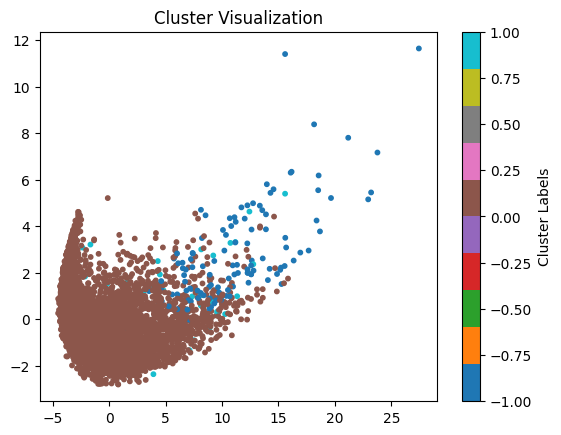

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
reduced_embeddings = PCA(n_components=2).fit_transform(distance_matrix)

# Plot clusters
plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1],
    c=adjusted_labels, cmap='tab10', s=10
)
plt.colorbar(label="Cluster Labels")
plt.title("Cluster Visualization")
plt.show()



### Checking for must-link & cannot-link violations

In [12]:
# Cannot-link violations
cannot_violations = [
    (i, j) for i, j in cannot_link_pairs if adjusted_labels[i] == adjusted_labels[j] and adjusted_labels[i] != -1
]
print(f"Cannot-Link Violations: {len(cannot_violations)}")

# Must-link violations
must_violations = [
    (i, j) for i, j in must_link_pairs if adjusted_labels[i] != adjusted_labels[j]
]
print(f"Must-Link Violations: {len(must_violations)}")


Cannot-Link Violations: 0
Must-Link Violations: 0


### Number of noise points

In [13]:
noise_points = [i for i, label in enumerate(adjusted_labels) if label == -1]
print(f"Number of Noise Points: {len(noise_points)}")


Number of Noise Points: 115


In [25]:
total_points = len(adjusted_labels)
noise_percentage = len(noise_points) / total_points * 100
print(f"Percentage of Noise Points: {noise_percentage:.2f}%")


Percentage of Noise Points: 2.26%


### Find the text of the first 20 instances of a cluster

In [14]:
import pandas as pd

all_texts = train_data['TEXT'].tolist() + unlabeled_data['TEXT'].tolist()

cluster_id=0

# Combine embeddings, labels, and texts into a DataFrame
clustered_data = pd.DataFrame({
    'TEXT': all_texts,
    'CLUSTER': adjusted_labels  # From clustering
})

# Group by clusters and inspect
for cluster_id in np.unique(adjusted_labels):
    print(f"\nCluster {cluster_id}:")
    print(clustered_data[clustered_data['CLUSTER'] == cluster_id].head(20))  # Inspect first 20 texts



Cluster -1:
                                                  TEXT  CLUSTER
131  pope francis has condemned violence against wo...       -1
135                                                  …       -1
140  yes eu blamed georgia for over reacting to sos...       -1
174  we had huge winter storm moving which created ...       -1
186  i do not believe that there is corruption and ...       -1
188  marie therese metoyer dilsey pope jacob gasken...       -1
207  usa government thinks all citizens abroad are ...       -1
216         state of nj and teachers hate gov christie       -1
221  should seek mental health treatment for eye he...       -1
245  if we are not earning usa income or own usa as...       -1
261  if human beings are created by gods then human...       -1
305  no surprises act enables postmedical care rati...       -1
330                                     hires perverts       -1
340  its not a tattoo its a moko kauae its a visual...       -1
382        messy over selfs

### For noise isntances

In [66]:
import pandas as pd
pd.set_option('display.max_colwidth', None)  # Set to None for unlimited width
print("\nNoise Points:")
print(clustered_data[clustered_data['CLUSTER'] == -1].head(20))



Noise Points:
                                                                                                                                                                                                 TEXT  \
0                                                                                                  employees are either pedophiles or trying to recruit gay men to pleasure their gay anchors at whim   
1    how about this lets go to retard war lets see who gets nuked first cause thats what we want right lets go pussies man up and kill all of us tired of all this bullshit you guys keep lying about   
2                                                                                                                                                                      lol you sick whiny tds pussies   
3                                                                                                                          she is a dumbass a public embarrassment for her family ble

In [78]:
all_texts = train_data['TEXT'].tolist() + unlabeled_data['TEXT'].tolist()


# Cluster label 3151 and 4820
print(f"Cluster Label: {adjusted_labels[3151]}")

# Text
print(f"Text: {all_texts[3151]}")


Cluster Label: 0
Text: f is colder than c…


### Uncertain pairs extraction

In [68]:
import numpy as np

def select_uncertain_pairs(distance_matrix, cluster_labels):
    """
    Select uncertain positive and negative pairs based on the clustering results and distance matrix.

    Parameters:
    - distance_matrix (ndarray): Pairwise distance matrix (n x n).
    - cluster_labels (ndarray): Cluster labels for each point.

    Returns:
    - uncertain_positive_pairs (list): List of (index1, index2, distance) for uncertain positive pairs.
    - uncertain_negative_pairs (list): List of (index1, index2, distance) for uncertain negative pairs.
    """
    uncertain_positive_pairs = []  # For storing uncertain positive pairs
    uncertain_negative_pairs = []  # For storing uncertain negative pairs

    unique_clusters = np.unique(cluster_labels[cluster_labels != -1])  # Ignore noise (-1)

    # Uncertain Positive Pairs
    for cluster in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) > 1:
            # Find the pair with the maximum distance within the cluster
            max_dist = -np.inf
            best_pair = None
            for i in cluster_indices:
                for j in cluster_indices:
                    if i < j:  # Avoid duplicate comparisons
                        dist = distance_matrix[i, j]
                        if dist > max_dist:
                            max_dist = dist
                            best_pair = (i, j, dist)
            if best_pair:
                uncertain_positive_pairs.append(best_pair)

    # Uncertain Negative Pairs
    for cluster1 in unique_clusters:
        for cluster2 in unique_clusters:
            if cluster1 < cluster2:  # Avoid duplicate comparisons
                cluster1_indices = np.where(cluster_labels == cluster1)[0]
                cluster2_indices = np.where(cluster_labels == cluster2)[0]
                # Find the pair with the minimum distance between the two clusters
                min_dist = np.inf
                best_pair = None
                for i in cluster1_indices:
                    for j in cluster2_indices:
                        dist = distance_matrix[i, j]
                        if dist < min_dist:
                            min_dist = dist
                            best_pair = (i, j, dist)
                if best_pair:
                    uncertain_negative_pairs.append(best_pair)

    return uncertain_positive_pairs, uncertain_negative_pairs


In [82]:
# Select uncertain pairs
uncertain_positive_pairs, uncertain_negative_pairs = select_uncertain_pairs(distance_matrix, adjusted_labels)

# Display results
print("Uncertain Positive Pairs (within clusters):")
for pair in uncertain_positive_pairs[:10]:
    print(f"Pair: {pair[0]} and {pair[1]}, Distance: {pair[2]:.4f}")

print("\nUncertain Negative Pairs (across clusters):")
for pair in uncertain_negative_pairs[:10]:
    print(f"Pair: {pair[0]} and {pair[1]}, Distance: {pair[2]:.4f}")


Uncertain Positive Pairs (within clusters):
Pair: 3151 and 4820, Distance: 0.5935
Pair: 21 and 79, Distance: 0.5037

Uncertain Negative Pairs (across clusters):
Pair: 703 and 46, Distance: 0.0194


###  Uncertain pairs annotation

In [83]:
def annotate_and_update_constraints(
    uncertain_positive_pairs, uncertain_negative_pairs,
    all_texts, must_link_pairs, cannot_link_pairs
):
    """
    Annotates uncertain pairs and updates must-link and cannot-link constraints.

    Parameters:
    - uncertain_positive_pairs (list): List of uncertain positive pairs (index1, index2, distance).
    - uncertain_negative_pairs (list): List of uncertain negative pairs (index1, index2, distance).
    - all_texts (list): List of texts corresponding to embeddings.
    - must_link_pairs (list): Existing list of must-link pairs (to be updated).
    - cannot_link_pairs (list): Existing list of cannot-link pairs (to be updated).

    Returns:
    - must_link_pairs: Updated must-link pairs.
    - cannot_link_pairs: Updated cannot-link pairs.
    """
    print("Annotating Uncertain Positive Pairs (Within Clusters):")
    for i, j, dist in uncertain_positive_pairs:
        print(f"\nPair: ({i}, {j}), Distance: {dist:.4f}")
        print(f"Text 1: {all_texts[i]}")
        print(f"Text 2: {all_texts[j]}")
        decision = input("Should these belong in the same cluster? (y/n): ").strip().lower()
        if decision == "y":
            must_link_pairs.append((i, j))
        elif decision == "n":
            cannot_link_pairs.append((i, j))

    print("\nAnnotating Uncertain Negative Pairs (Across Clusters):")
    for i, j, dist in uncertain_negative_pairs:
        print(f"\nPair: ({i}, {j}), Distance: {dist:.4f}")
        print(f"Text 1: {all_texts[i]}")
        print(f"Text 2: {all_texts[j]}")
        decision = input("Should these belong in different clusters? (y/n): ").strip().lower()
        if decision == "y":
            cannot_link_pairs.append((i, j))
        elif decision == "n":
            must_link_pairs.append((i, j))

    return must_link_pairs, cannot_link_pairs


In [84]:
# Annotate the selected pairs
must_link_pairs, cannot_link_pairs = annotate_and_update_constraints(
    uncertain_positive_pairs, uncertain_negative_pairs,
    all_texts, must_link_pairs, cannot_link_pairs
)

# Confirm updates
print(f"Updated Must-Link Pairs: {len(must_link_pairs)}")
print(f"Updated Cannot-Link Pairs: {len(cannot_link_pairs)}")


Annotating Uncertain Positive Pairs (Within Clusters):

Pair: (3151, 4820), Distance: 0.5935
Text 1: f is colder than c…
Text 2: you stand up to nazis the same way you stand up to the ccp they dont have any right to hurt or murder you because of your skincolor ethnicity religion the nazis thought they had the right to gas children to death because no one stood up to them before it was too late peace
Should these belong in the same cluster? (y/n): n

Pair: (21, 79), Distance: 0.5037
Text 1: damn this man is handsome
Text 2: opium is a source of jobs and wealth for the poorest of poor of afghanistan opium production is worth about billion dollars
Should these belong in the same cluster? (y/n): y

Annotating Uncertain Negative Pairs (Across Clusters):

Pair: (703, 46), Distance: 0.0194
Text 1: very cool
Text 2: very valid point
Should these belong in different clusters? (y/n): y
Updated Must-Link Pairs: 3616
Updated Cannot-Link Pairs: 852
